In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import scipy.sparse as sp
import pickle
import matplotlib.pyplot as plt
from recmetrics import intra_list_similarity


df_anime = pd.read_csv('../dataset/df_anime.csv')
df_ratings = pd.read_csv('../dataset/df_ratings.csv')

In [2]:
df_anime.head(2)

,anime_id,name,english_name,genres,studios,image_url,content,content_prep
0,1,Cowboy Bebop,Cowboy Bebop,"Action, Award Winning, Sci-Fi",Sunrise,https://cdn.myanimelist.net/images/anime/4/196...,"Cowboy Bebop Sunrise Action, Award Winning, Sc...","['cowboy', 'bebop', 'sunris', 'action', 'award..."
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,"Action, Sci-Fi",Bones,https://cdn.myanimelist.net/images/anime/1439/...,"Cowboy Bebop: Tengoku no Tobira Bones Action, ...","['cowboy', 'bebop', 'tengoku', 'tobira', 'bone..."


In [3]:
# Step 2: Preprocess data and compute cosine similarity
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_anime['content_prep'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [4]:
# Cache for CBF results
cbf_cache = {}

# Content-Based Filtering (CBF) Function with Cache
def get_cbf_recommendations_cached(anime_name, cosine_sim, topN=5):
    anime_name_lower = anime_name.lower()
    if anime_name_lower in cbf_cache:
        return cbf_cache[anime_name_lower]
    
    idx = df_anime.index[(df_anime['name'].str.lower() == anime_name_lower) | 
                         (df_anime['english_name'].str.lower() == anime_name_lower)].tolist()
    if not idx:
        return pd.DataFrame()
    
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:topN+1]
    anime_indices = [i[0] for i in sim_scores]
    
    recommendations = pd.DataFrame({
        'anime_id': df_anime['anime_id'].iloc[anime_indices],
        'name': df_anime['name'].iloc[anime_indices],
        'cosine_sim': [i[1] for i in sim_scores]
    })
    
    cbf_cache[anime_name_lower] = recommendations
    return recommendations

In [5]:
# Content-Based Filtering Example
print("\nContent-Based Filtering Recommendations for 'Naruto':")
cbf_recommendations = get_cbf_recommendations_cached('Naruto', cosine_sim, topN=5)
print(cbf_recommendations)


Content-Based Filtering Recommendations for 'Naruto':
       anime_id                        name  cosine_sim
4004      10075                 Naruto x UT    0.965021
4864      16870  The Last: Naruto the Movie    0.888431
10558     53236              Road of Naruto    0.766079
1312       1735          Naruto: Shippuuden    0.757786
1822       2472  Naruto: Shippuuden Movie 1    0.725384


In [6]:
# Step 4: Train the Collaborative Filtering (CF) model
reader = Reader(rating_scale=(1, 10))
rating_df = Dataset.load_from_df(df_ratings[['user_id', 'anime_id', 'rating']], reader)
trainset, testset = train_test_split(rating_df, test_size=0.2, random_state=42)

algo_knn = KNNBasic(k=100, sim_options={"name": "cosine", "user_based": False})
algo_knn.fit(trainset)
predictions = algo_knn.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [7]:
# Collaborative Filtering (CF) Function
def get_cf_recommendations(user_id, predictions, df_anime, topN=5):
    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    if not user_predictions:
        return pd.DataFrame()
    
    user_predictions = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:topN]
    result_data = []
    
    for pred in user_predictions:
        anime_id = pred.iid
        if anime_id not in df_anime['anime_id'].values:
            continue
        anime_title = df_anime.loc[df_anime['anime_id'] == anime_id, 'name'].iloc[0]
        est = pred.est
        result_data.append({'anime_id': anime_id, 'name': anime_title, 'est': est})
    
    return pd.DataFrame(result_data)

In [8]:
# Collaborative Filtering Example for a specific user
user_id_example = 4
print(f"\nCollaborative Filtering Recommendations for User {user_id_example}:")
cf_recommendations = get_cf_recommendations(user_id_example, predictions, df_anime, topN=5)
print(cf_recommendations)


Collaborative Filtering Recommendations for User 4:
   anime_id                        name       est
0     22789                   Barakamon  7.278518
1       121         Fullmetal Alchemist  7.208211
2      1689       Byousoku 5 Centimeter  7.167509
3     31043     Boku dake ga Inai Machi  7.107856
4      6347  Baka to Test to Shoukanjuu  7.097398


In [9]:
def get_hybrid_recommendations_weighted(user_id, df_ratings, df_anime, cosine_sim, predictions, topN=10, weight_cbf=0.7, weight_cf=0.3):
    user_rated_anime_ids = df_ratings[df_ratings['user_id'] == user_id]['anime_id'].unique()
    if len(user_rated_anime_ids) == 0:
        return pd.DataFrame()

    cbf_result = pd.DataFrame()
    for anime_id in user_rated_anime_ids:
        if anime_id not in df_anime['anime_id'].values:
            continue
        anime_name = df_anime.loc[df_anime['anime_id'] == anime_id, 'name'].values[0]
        cbf_recommendations = get_cbf_recommendations_cached(anime_name, cosine_sim, topN)
        if cbf_recommendations is not None and not cbf_recommendations.empty:
            cbf_recommendations['sim/est'] = cbf_recommendations['cosine_sim']
            cbf_recommendations = cbf_recommendations.drop(columns=['cosine_sim'])
            cbf_result = pd.concat([cbf_result, cbf_recommendations])

    if not cbf_result.empty:
        cbf_result['sim/est'] = (cbf_result['sim/est'] - cbf_result['sim/est'].min()) / (cbf_result['sim/est'].max() - cbf_result['sim/est'].min()) * 9 + 1
        cbf_result = cbf_result.drop_duplicates(subset='anime_id', keep='first').head(topN // 2)
        cbf_result['weight'] = weight_cbf
    else:
        cbf_result = pd.DataFrame()

    cf_result = get_cf_recommendations(user_id, predictions, df_anime, topN // 2)
    if not cf_result.empty:
        cf_result['sim/est'] = cf_result['est']
        cf_result = cf_result.drop(columns=['est'])
        cf_result['weight'] = weight_cf
    else:
        cf_result = pd.DataFrame()

    recommended = cbf_result.to_dict('records') + cf_result.to_dict('records')
    recommended_df = pd.DataFrame(recommended)

    return recommended_df if not recommended_df.empty else pd.DataFrame()

In [10]:
# Hybrid Recommendations Example for the same user
print(f"\nHybrid Recommendations for User {user_id_example}:")
hybrid_recommendations = get_hybrid_recommendations_weighted(user_id_example, df_ratings, df_anime, cosine_sim, predictions, topN=10, weight_cbf=0.7, weight_cf=0.3)
print(hybrid_recommendations)


Hybrid Recommendations for User 4:
   anime_id                                               name   sim/est  \
0     18617                               Girls & Panzer Movie  8.226916   
1     40656        Girls & Panzer: Saishuushou Part 2 Specials  7.348496   
2     49690        Girls & Panzer: Saishuushou Part 3 Specials  7.348496   
3     32511        Girls & Panzer: Nihon Senshadou Renmei News  5.325231   
4     18619  Girls & Panzer: Kore ga Hontou no Anzio-sen desu!  5.084184   
5     22789                                          Barakamon  7.278518   
6       121                                Fullmetal Alchemist  7.208211   
7      1689                              Byousoku 5 Centimeter  7.167509   
8     31043                            Boku dake ga Inai Machi  7.107856   
9      6347                         Baka to Test to Shoukanjuu  7.097398   

   weight  
0     0.7  
1     0.7  
2     0.7  
3     0.7  
4     0.7  
5     0.3  
6     0.3  
7     0.3  
8     0.3  
9     0

# EVALUASI MAE

In [11]:
# Batch Processing and Weighted MAE Calculation
def calculate_hybrid_mae_weighted(batch_size=100, weight_cbf=0.7, weight_cf=0.3):
    total_error = 0
    total_count = 0
    unique_users = test_data['user_id'].unique()
    
    for i in range(0, len(unique_users), batch_size):
        batch_users = unique_users[i:i+batch_size]
        batch_data = test_data[test_data['user_id'].isin(batch_users)]
        
        predictions = algo_knn.test(testset)
        pred_df = pd.DataFrame(predictions, columns=['user_id', 'anime_id', 'rating', 'est', 'details'])
        pred_df['error'] = abs(pred_df['est'] - pred_df['rating'])
        
        for user_id in batch_users:
            hybrid_recommendations = get_hybrid_recommendations_weighted(user_id, df_ratings, df_anime, cosine_sim, predictions, topN=10, weight_cbf=weight_cbf, weight_cf=weight_cf)
            if hybrid_recommendations.empty:
                continue
            
            user_ratings = batch_data[batch_data['user_id'] == user_id]
            merged_df = hybrid_recommendations.merge(user_ratings, on='anime_id', how='inner')
            
            if merged_df.empty:
                continue
            
            # Calculate weighted MAE
            merged_df['error'] = merged_df['weight'] * abs(merged_df['sim/est'] - merged_df['rating'])
            total_error += merged_df['error'].sum()
            total_count += len(merged_df)
    
    mae_hybrid = total_error / total_count if total_count > 0 else None
    return mae_hybrid

# Convert testset to DataFrame
test_data = pd.DataFrame(testset, columns=['user_id', 'anime_id', 'rating'])

# Calculate MAE with weighted scores
mae_hybrid = calculate_hybrid_mae_weighted(batch_size=100, weight_cbf=0.7, weight_cf=0.3)
print("MAE for Hybrid Model with Weighted Scores:", mae_hybrid)


MAE for Hybrid Model with Weighted Scores: 0.4173484935469464


In [12]:
# Menghitung MAE untuk model CF
mae_cf = accuracy.mae(predictions)
print("MAE for CF Model:", mae_cf)

MAE:  1.1167
MAE for CF Model: 1.1166823533499453


In [13]:
# MAE Calculation for CBF with Normalization
def calculate_cbf_mae():
    total_error = 0
    total_count = 0
    
    for user_id in test_data['user_id'].unique():
        user_ratings = test_data[test_data['user_id'] == user_id]
        
        for _, row in user_ratings.iterrows():
            anime_name_series = df_anime.loc[df_anime['anime_id'] == row['anime_id'], 'name']
            
            # Check if the anime name exists
            if anime_name_series.empty:
                continue
            
            anime_name = anime_name_series.values[0]
            cbf_recommendations = get_cbf_recommendations_cached(anime_name, cosine_sim, topN=5)
            if cbf_recommendations.empty:
                continue
            
            # Normalize Cosine Similarity
            cbf_recommendations['cosine_sim_normalized'] = cbf_recommendations['cosine_sim'] * 9 + 1
            
            # Calculate MAE for CBF
            for _, rec_row in cbf_recommendations.iterrows():
                if rec_row['anime_id'] == row['anime_id']:
                    error = abs(rec_row['cosine_sim_normalized'] - row['rating'])
                    total_error += error
                    total_count += 1
    
    mae_cbf = total_error / total_count if total_count > 0 else None
    return mae_cbf

# Menghitung dan menampilkan hasil MAE untuk CBF
mae_cbf = calculate_cbf_mae()
print("MAE for CBF Model:", mae_cbf)


MAE for CBF Model: 2.318180157951166


# AKHIR EVALUASI MAE

# EVALUASI ILS

In [11]:

genres = [
    "Adventure", "Avant Garde", "Award Winning", "Comedy", "Drama", 
    "Fantasy", "Gourmet", "Horror", "Mystery", "Romance", "Sci-Fi", 
    "Slice of Life", "Sports", "Supernatural", "Suspense", "Action"
]

# Ensure Genres column is a list of genres
df_anime['genres'] = df_anime['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Explode genres into individual rows
df_anime_exploded = df_anime.explode('genres')

# Creating a binary genre matrix
matrix_genres = pd.get_dummies(df_anime_exploded['genres']).groupby(df_anime_exploded['anime_id']).sum()


In [12]:
matrix_genres.head()

,Action,Adventure,Avant Garde,Award Winning,Comedy,Drama,Fantasy,Gourmet,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
anime_id,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [13]:
def calculate_ils(recommendation, matrix_genres):
    if recommendation.empty:
        return np.nan
    genre_vectors = matrix_genres.loc[recommendation['anime_id']]
    similarity_matrix = cosine_similarity(genre_vectors)
    upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
    mean_similarity = np.mean(similarity_matrix[upper_triangle_indices])
    return mean_similarity

In [17]:
def create_ils_table(model, top_n_values, test_results):
    table = []
    for top_n in top_n_values:
        row = {
            'model': model,
            'jumlah n': top_n,
            'test1': np.nanmean(test_results[0][top_n]),
            'test2': np.nanmean(test_results[1][top_n]),
            'test3': np.nanmean(test_results[2][top_n]),
            'rata"': np.nanmean([np.nanmean(test_results[0][top_n]), np.nanmean(test_results[1][top_n]), np.nanmean(test_results[2][top_n])])
        }
        table.append(row)
    return table

# Set topN values to test
top_ns = [6, 8, 10]

# Initialize dictionaries to store ILS values
user_cbf_ils_values = {topN: [] for topN in top_ns}
user_hybrid_ils_values = {topN: [] for topN in top_ns}
user_cf_ils_values = {topN: [] for topN in top_ns}

for user_id in df_ratings['user_id'].sample(1000, random_state=42):
    user_anime_ids = df_ratings[df_ratings['user_id'] == user_id]['anime_id'].values
    if len(user_anime_ids) == 0:
        continue  # Skip to the next user if no anime is rated by this user

    # Ensure the anime_id exists in df_anime
    anime_name_series = df_anime.loc[df_anime['anime_id'] == user_anime_ids[0], 'name']
    if anime_name_series.empty:
        continue  # Skip if the anime_id doesn't exist in df_anime

    anime_name = anime_name_series.values[0]
    
    for topN in top_ns:
        # CBF recommendations
        cbf_recommendations = get_cbf_recommendations_cached(anime_name, cosine_sim, topN=topN)
        cbf_ils = calculate_ils(cbf_recommendations, matrix_genres)
        user_cbf_ils_values[topN].append(cbf_ils)

        # CF recommendations
        cf_recommendations = get_cf_recommendations(user_id, predictions, df_anime, topN=topN)
        cf_ils = calculate_ils(cf_recommendations, matrix_genres)
        user_cf_ils_values[topN].append(cf_ils)

        # Hybrid recommendations
        hybrid_recommendations = get_hybrid_recommendations_weighted(user_id, df_ratings, df_anime, cosine_sim, predictions, topN=topN)
        hybrid_ils = calculate_ils(hybrid_recommendations, matrix_genres)
        user_hybrid_ils_values[topN].append(hybrid_ils)


# Create result tables for CBF, CF, and Hybrid models
cbf_table = create_ils_table('cbf', top_ns, [user_cbf_ils_values for _ in range(3)])
cf_table = create_ils_table('cf', top_ns, [user_cf_ils_values for _ in range(3)])
hybrid_table = create_ils_table('hybrid', top_ns, [user_hybrid_ils_values for _ in range(3)])

# Combine CBF, CF, and Hybrid tables into a final table
final_table = pd.DataFrame(cbf_table + cf_table + hybrid_table)
print(final_table)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129

    model  jumlah n     test1     test2     test3     rata"
0     cbf         6  0.505034  0.505034  0.505034  0.505034
1     cbf         8  0.505034  0.505034  0.505034  0.505034
2     cbf        10  0.505034  0.505034  0.505034  0.505034
3      cf         6  0.308798  0.308798  0.308798  0.308798
4      cf         8  0.302304  0.302304  0.302304  0.302304
5      cf        10  0.301962  0.301962  0.301962  0.301962
6  hybrid         6  0.387691  0.387691  0.387691  0.387691
7  hybrid         8  0.380886  0.380886  0.380886  0.380886
8  hybrid        10  0.374583  0.374583  0.374583  0.374583


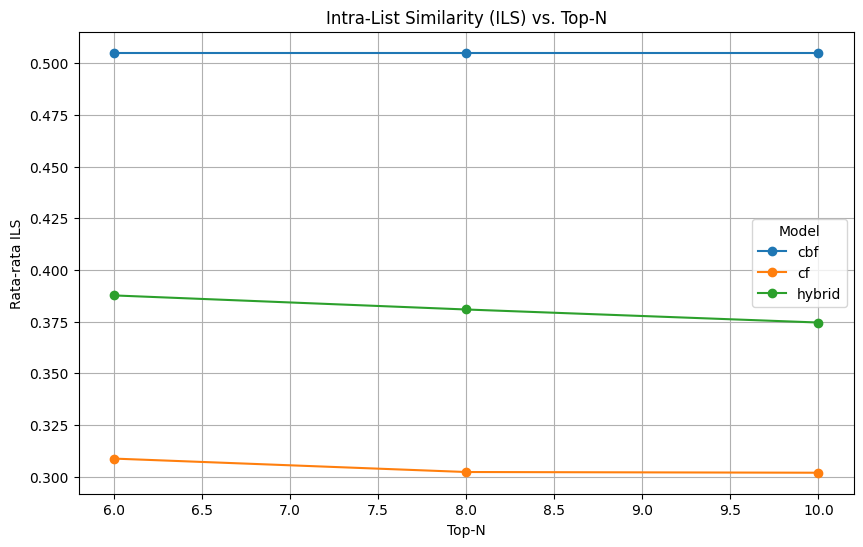

In [18]:
import matplotlib.pyplot as plt

# Plotting the results from final_table
plt.figure(figsize=(10, 6))
for model in final_table['model'].unique():
    model_data = final_table[final_table['model'] == model]
    plt.plot(model_data['jumlah n'], model_data['rata"'], marker='o', label=model)

plt.title('Intra-List Similarity (ILS) vs. Top-N')
plt.xlabel('Top-N')
plt.ylabel('Rata-rata ILS')
plt.legend(title='Model')
plt.grid(True)

# Save the plot as PNG
output_filename = 'ils_final_results.png'
plt.savefig(output_filename)
plt.show()


# AKHIR EVALUASI ILS

In [1]:
# MODEL

In [ ]:

# Simpan model CF, cosine similarity matrix, DataFrame, dan prediksi ke dalam file pickle
with open('cf_model.pkl', 'wb') as f:
    pickle.dump(algo_knn, f)
with open('cbf_cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)
with open('df_anime.pkl', 'wb') as f:
    pickle.dump(df_anime, f)
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)